# Section peut-être à enlever?

Pouvoir d'arrêt collisionnel des protons:

$$\frac{S_{col}}{\rho}=-\left(\frac{d T}{\rho dx}\right)_{col}=NZ\int_0^{T_e^{max}}T'\left(\frac{d\sigma}{dT'}\right)_{col}d T'$$

$$T_e^{max}=\frac{2m_e c^2(\gamma^2 -1)}{1+2\gamma\frac{m_e}{m_p}+\left(\frac{m_e}{m_p}\right)^2}$$

$$-\left(\frac{dT}{dx}\right)_{col}=2\pi r^2_em_ec^2n_e\frac{Z^2}{\beta^2}\left[\ln\left(\frac{2m_ec^2(\gamma^2-1)T_e^{max}}{I^2}\right)-2\beta^2-\delta-2\frac{C}{Z}+2ZL_1+2Z^2L_2\right]$$

$$S_{col}(T)=2\pi r_e^2 m_e c^2 n_e\beta^{-2}\left[\ln\left(\frac{2m_ec^2\beta^2\gamma^2 T_e^{max}}{I^2}\right)-2\beta^2\right]$$

## Constantes et modules
$$\text{\textcolor{red}{IL FAUDRAIT SUREMENT FAIRE UNE MINI INTRO??}}$$
Définissons d'abord toutes les constantes qui seront utilisées par les fonction définies ci-après, et importons les modules nécessaires ($\textcolor{red}{\text{METTRE SOURCES}}$):

In [43]:
import math
import timeit
from scipy.stats import moyal
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline


c = 2.99792458 * 10**8                  # vitesse de la lumière [m/s]
re = 2.8179409238 * 10**(-15)           # rayon classique de l'électron [m]
me = 9.1093837015 * 10**(-31)           # masse au repos de l'électron [kg]
mp = 1.6726219236951 * 10**(-27)        # masse au repos du proton [kg]

## Densité électronique d'un milieu

En premier lieu, on cherche à déterminer la densité électronique pour un milieu donné, en nombre d'électrons par centimètre cube. Pour ce faire, on a besoin de trois données pour chaque composant distinct du milieu: le numéro atomique ($Z_n$), la fraction massique ($F_n$) et la masse volumique ($M_n$). Toutes ces données sont tabulées sur diverses pages web, notamment celle du NIST ($\textcolor{red}{\text{METTRE SOURCES OFFICIELLES}}$).

Pour obtenir la densité électronique à partir de ces trois données, on doit déterminer le nombre d'électrons de chaque composant distinct indépendamment. Cela se traduit mathématiquement par :

$$N_e=\sum_{i=1}^{n}\frac{\rho}{M_i}Z_i\cdot F_n\cdot N_A$$

Où $N_e$ est la densité électronique en $\text{électrons/cm}^3$, et $N_A=6.02214076\times10^{23}$ atomes/mol est le nombre d'Avogadro. On code cette expression dans la fonction *densiteelec* qui prend en entrée la masse volumique en $\text{g/cm}^3$ du milieu et une liste comprenant $Z$, $F$ et $M$ pour chaque composant du milieu et retourne la densité électronique en $\text{électrons/cm}^3$.

In [25]:
# Format de données: données = [[Z1, P1, M1], [Z2, P2, M2], ...]
# où Zn est le numéro atomique, Fn est la fraction massique et Mn est la masse volumique
# Chaque liste individuelle dans la liste "données" représente un composant
# distinct du milieu (par exemple, H et O pour l'eau).

def densiteelec(rho, donnees):
    nombreelec = []
    for i in donnees:
        nombreelec.append(i[1]*rho/i[2]*i[0]*6.02214076*10**(23))
    return sum(nombreelec)

Pouvant maintenant calculer les densités électroniques, il sera utile de les calculer et d'enregistrer ces valeurs dans un dictionnaire afin de pouvoir y accéder aisément plus tard. Définissons donc le dictionnaire "milieu", qui contiendra trois valeurs : la densité électronique (que nous pouvons maintenant calculer), ainsi que la masse volumique et l'énergie d'excitation moyenne, toutes deux tirées directement du site du NIST ($\textcolor{red}{\text{METTRE SOURCES OFFICIELLES}}$). Toutes les données utilisées pour faire les calculs de densité électronique ont aussi été tirées du site web du NIST:

In [26]:
# milieu = {"milieu1": (densité électronique [e/cm^3], rho [g/cm^3], énergie moy d'activation [J])}

rho_eau = 1
donnees_eau = [[1, 0.111894, 1.0079], [8, 0.888106, 15.999]]
I_eau = 75 / (6.242*10**18)

rho_os = 1.85
donnees_os = [
    [1, 0.063984, 1.0079], 
    [6, 0.278000, 12.011], 
    [7, 0.027000, 14.007], 
    [8, 0.410016, 15.999], 
    [12, 0.002000, 24.305], 
    [15, 0.070000, 30.974], 
    [16, 0.002000, 32.06], 
    [20, 0.147000, 40.078]
    ]
I_os = 91.9 / (6.242*10**18)

milieu = {}
milieu["eau"] = (densiteelec(rho_eau, donnees_eau), rho_eau, I_eau)
milieu["os"] = (densiteelec(rho_os, donnees_os), rho_os, I_os)

Lorsqu'on aura des fonctions qui feront appel à l'une de ces deux variables, on pourra donc simplement passer en argument le milieu dans lequel on souhaite évaluer la fonction; cela nous évitera d'avoir à "hard-code" des valeurs ou encore à programmer plusieurs fonctions distinctes. Les valeurs de densité électronique pour l'eau et l'os compact sont donc :

In [27]:
print("densité électronique de l'eau :", milieu["eau"][0], "électrons / cm^3")
print("densité électronique de l'os compact :", milieu["os"][0], "électrons / cm^3")

densité électronique de l'eau : 3.342876611513782e+23 électrons / cm^3
densité électronique de l'os compact : 5.9059477632844346e+23 électrons / cm^3


## Pouvoir d'arrêt

On veut maintenant coder une fonction qui calcule le pouvoir d'arrêt d'un milieu en fonction de l'énergie cinétique du proton qui s'y trouve. On sait que le pouvoir d'arrêt est donné par la fonction mathématique suivante :
$$S_{col}(T)=2\pi r_e^2 m_e c^2 n_e\beta^{-2}\left[\ln\left(\frac{2m_ec^2\beta^2\gamma^2 T_e^{max}}{I^2}\right)-2\beta^2\right]$$
avec les quantités suivantes :
$$T^{max}_e = \frac{2m_ec^2(\gamma^2-1)}{1+\big(\frac{m_e}{m_p})^2 + 2\frac{m_e}{m_p}\gamma}$$
$$\gamma = \frac{T}{m_pc^2} + 1$$
$$\beta = \sqrt{1-\gamma^{-2}}$$
où $r_e$ est le rayon classique de l'électron, $n_e$ est la densité électronique du milieu, $Z$ est la charge de la particule, $I$ est l'énergie moyenne d'excitation du milieu et $T$ est l'énergie cinétique de la particule. On commence par coder une fonction qui retourne l'énergie maximale transférable $T_e^{max}$ :

In [28]:
def e_transf_max(gamma):
    te_max = 2 * me * c**2 * (gamma**2 - 1) / (1 + 2*gamma*me/mp + (me/mp)**2)
    return te_max

On définit ensuite la fonction *pouvoir_arret* qui retourne le pouvoir d'arrêt pour un proton en fonction du milieu et de l'énergie cinétique du proton en MeV. Tout d'abord, la fonction convertit l'énergie cinétique et la densité électronique en unités SI. Elle calcule ensuite les quantités $\gamma$, $\beta$ et $T_e^{max}$. Finalement elle calcule le pouvoir d'arrêt et retourne la valeur convertie en MeV.

In [29]:
# Pouvoir d'arrêt [MeV/m]
# Arguments :
# T : énergie cinétique du proton [MeV]
# mil : clé pour appeler le bon milieu dans le dictionnaire "milieu"

def pouvoir_arret(T, mil): 

    # T de MeV à J
    T = T / 6241506479963.2

    # densité électronique de g/cm-3 à kg/m-3
    ne = milieu[mil][0]*10**6

    # Calcul de gamma et beta
    gamma = T / (mp * c**2) + 1
    beta = np.sqrt(1 - gamma**(-2))

    # Calcul de l'énergie de transfert maximal
    te_max = e_transf_max(gamma)

    const = 2 * np.pi * re**2 * me * c**2 * ne / beta**2
    parenth = np.log(2 * me * c**2 * gamma**2 * te_max / milieu[mil][2]**2) - (2 * beta**2)

    return (const * parenth) * 6241506479963.2

Maintenant qu'on a une fonction qui permet de calculer le pouvoir d'arrêt, on peut tracer le pouvoir d'arrêt en fonction de l'énergie cinétique du proton pour l'eau liquide et pour l'os compact. On considère un intervalle de 3-250 MeV pour l'énergie cinétique du proton, car les faisceaux de protonthérapie ont typiquement une énergie cinétique initiale de 70-250 MeV et car notre modèle théorique ne s'applique pas pour des protons avec une énergie cinétique de moins de 3 MeV ($\text{\textcolor{red}{source officielle consignes?, est-ce qu'on trace les deux courbes sur le même graphique?}}$).

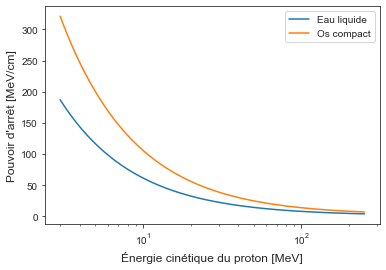

In [59]:
# Énergie cinétique du proton
T = np.linspace(3, 250, 1000)

# Pouvoir d'arrêt de l'eau liquide en MeV/cm
pouv_arr_eau = []
for i in T:
    pouv_arr_eau.append(pouvoir_arret(i, 'eau') / 100)

# Pouvoir d'arrêt de l'os compact en MeV/cm
pouv_arr_os = []
for i in T:
    pouv_arr_os.append(pouvoir_arret(i, 'os') / 100)

pouv_arr_fig = plt.figure(figsize=(8,5))
sns.set_style("ticks")
plt.plot(T, pouv_arr_eau, label='Eau liquide')
plt.plot(T,pouv_arr_os, label='Os compact')
plt.xlabel('Énergie cinétique du proton [MeV]', fontsize=14)
plt.ylabel("Pouvoir d'arrêt [MeV/cm]", fontsize=14)
plt.xscale('log')
plt.legend()
plt.show()

Cette fonction prend en entrée la masse volumique en $\text{g/cm}^3$ du milieu et une liste comprenant $Z$, $F$ et $M$ pour chaque composant du milieu et retourne la densité électronique en $\text{électrons/cm}^3$.

Voici les graphiques demandés à la question 1, IL RESTERA À AJOUTER LE TEXTE EXPLICATIF ET LA DÉMARCHE, GENRE JE PENSE QU'IL FAUDRA PARLER DE COMMENT ON FAIT LA FONCTION DU POUVOIR D'ARRÊT, JSP? ET AUSSI PARLER DE LA FONCTION QUI CALCULE LA DENSITÉ D'ÉLECTRONS

CHANGER LES UNITÉS ET POSSIBLEMENT LES LABELS DES GRAPHIQUES POUR S'ASSURER D'AVOIR LES BONS TRUCS

QUESTION 2

Le fait de considérer seulement l'effet de l'interaction entre les électrons et les protons sur le pouvoir est légitime car cet effet dépasse largement les autres effets qui influencent le pouvoir d'arrêt. Les deux autres phénomènes principaux sont l'effet Bremsstrahlung, qui cause des pertes radiatives, et l'interaction entre les protons et les noyaux atomiques. Selon les données du NIST (SOURCE) représentées à la figure 4, on observe que l'effet de l'interaction entre les protons et les noyaux atomiques dans l'os compact est faible comparée à l'interaction entre les protons et les électrons, spécialement pour la plage d'intérêt, c'est-à-dire pour une énergie cinétique de 3 à 250 MeV. Les données du NIST pour l'eau liquide (SOURCE ET FIGURE 3!!???) montrent un comportement similaire. Par exemple, pour une énergie cinétique de 100 MeV, selon le NIST, les pertes causées par l'interaction proton-électron dans l'eau liquide sont de 45,6 MeV tandis que les pertes causées par l'intéraction proton-noyaux atomiques est de 26,0 keV. Les pertes causées par les interactions avec les électrons sont donc environ 1754 fois plus grandes que celles causées par les interactions avec les noyaux atomiques dans cette situation.

<center><img src="PouvoirArretTotalEau.png"/></center>
<center>Figure 3. AJOUTER UN TITRE ET UNE RÉFÉRENCE AU NIST

<center><img src="PouvoirArretTotalOS.png"/></center>
<center>Figure 4. AJOUTER UN TITRE ET UNE RÉFÉRENCE AU NIST


Pour l'effet Bremsstrahlung, on peut déterminer l'ordre de grandeur des pertes radiatives des protons à partir des données sur les pertes radiatives des faisceaux d'électrons dans les différents milieux. Selon les données du NIST (SOURCE), les pertes radiatives maximales pour un faisceau d'électron dans l'eau liquide pour des énergies de 3 à 250 MeV sont de l'ordre de 1 MeV. Pour un faisceau de protons, la force électromagnétique issue de l'intéraction entre les protons et les électrons sera du même ordre de grandeur que pour un faisceau d'électrons, mais, comme la masse du proton est environ 1836 fois (SOURCE) plus grande que celle de l'électron, l'accélération des protons sera alors environ 1836 fois plus petit par la deuxième loi de Newton. Comme l'accélération cause les pertes radiatives, celles-ci seront également 1836 fois plus petites que pour un faisceau d'électrons. Les pertes seront alors de l'ordre du keV et seront négligeables comparées aux pertes dues aux interactions proton-électron, qui sont de l'ordre du MeV. On peut effectuer le même raisonnement pour l'os compact à partir des données du NIST et en arriver à la même conclusion.

QUESTION 3

Comme le pouvoir d'arrêt du milieu représente la quantité d'énergie que le proton perd lorsqu'il se propage dans le milieu, on voit logiquement que le proton pourra se propager plus loin si le pouvoir d'arrêt du milieu est faible. Il se propagera moins loin si le pouvoir d'arrêt est grand. Il est donc cohérent d'intégrer sur l'inverse du pouvoir d'arrêt afin de déterminer la portée du proton.

AJOUTER PLUS D'EXPLICATIONS???

QUESTION 4

On peut réécrire l'équation du pouvoir d'arrêt en fonction de $\gamma$ à l'aide des relations suivantes:
$$U = 2\pi r_e^2m_ec^2n_e$$
$$T = (\gamma-1)m_pc^2$$
$$T_e^{max} = \frac{a(\gamma^2-1)}{b + \delta\gamma}$$
$$\beta^2\gamma^2 = (\gamma^2-1)$$
où $a$, $b$ et $\delta$ sont des constantes qui dépendent des masses de l'électron et du proton. On En remplaçant dans dans l'équation du pouvoir d'arrêt, on a
$$S_{col} = U\frac{\gamma^2}{(\gamma^2-1)}\Bigg[\ln\bigg(\frac{2m_ec^2a(\gamma^2-1)^2}{I^2(b + \delta)}\bigg)\Bigg] - 2U$$
En posant les changements de variable d'intégration $T = T_i - T$ et $T = (\gamma-1)m_pc^2$, on obtient une intégrale de la forme suivante pour la portée:
$$R_{CSDA} = \rho m_pc^2\int \frac{\text{d}\gamma}{U\frac{\gamma^2}{(\gamma^2-1)}\Bigg[\ln\bigg(\frac{2m_ec^2a(\gamma^2-1)^2}{I^2(b + \delta)}\bigg)\Bigg] - 2U}$$
Une intégrale de cette forme ne possède pas de solution analytique connue, donc on doit la résoudre numériquement. On peut vérifier qu'elle n'a pas de solution analytique avec un logiciel de calcul tel que WolframAlpha.

QUESTION 5

Implémentons d'abord la méthode des trapèzes, étant donné que celle-ci sera nécessaire au fonctionnement de la méthode de Romberg:

In [ ]:
def trapeze(f, N, a, b, *args):
    h = (b-a)/N

    s = 0.5*f(a, *args)+0.5*f(b, *args)
    for i in range(1,N):
        s += f(a+i*h, *args)
    
    return h*s

Cette fonction prend en argument la fonction à intégrer f, le nombre de tranches N, les deux bornes d'intégration a et b, ainsi que des arguments optionnels propre à la fonction à intégrer. On peut maintenant implémenter la méthode de Romberg:

In [ ]:
def romberg(f, i_max, a, b, *args):
    Rn = []
    N = 1
    for i in range(i_max):
        Rn.append([trapeze(f, N, a, b, *args)])
        N = 2 * N
        for m in range(i):
            Rn[i].append(Rn[i][m] + (Rn[i][m] - Rn[i-1][m]) / (4**(m+1) - 1))
    return Rn[-1][-1]

On veut maintenant, à l'aide de ces deux algorithmes, évaluer la portée des protons dans l'eau et dans l'os compact. La portée est donnée par:

$$R_{CSDA}=\rho\int_0^{T_i}\frac{1}{S_{col}}$$

Où $\rho$ est la masse volumique du milieu en $kg/m^3$, $T_i$ est l'énergie d'entrée du proton en MeV, et $S_{col}$ est le pouvoir d'arrêt en MeV par mètre. On doit donc d'abord implémenter une fonction calculant le pouvoir d'arrêt d'un matériau donné avant de pouvoir déterminer la portée. Le pouvoir d'arrêt est donné par:

$$S_{col}(T)=2\pi r_e^2 m_e c^2 n_e\beta^{-2}\left[\ln\left(\frac{2m_ec^2\beta^2\gamma^2 T_e^{max}}{I^2}\right)-2\beta^2\right]$$

En remplaçant $\gamma$ et $\beta$ avec les expressions suivantes afin que l'expression soit en fonction de $T$:

$$\gamma = \frac{T}{m_p c^2}+1 \qquad \beta = \sqrt{1-\gamma^{-2}}$$

On implémente une fonction calculant l'énergie de transfert maximale, soit:

$$T_e^{max}=\frac{2 m_e c^2 (\gamma^2 - 1)}{1+2\gamma\frac{m_e}{m_p}+\left(\frac{m_e}{m_p}\right)^2}$$

In [ ]:
def e_transf_max(gamma):
    te_max = 2 * me * c**2 * (gamma**2 - 1) / (1 + 2*gamma*me/mp + (me/mp)**2)
    return te_max

On peut ensuite implémenter la fonction pouvoir_arret retournant le pouvoir d'arrêt en MeV/m et prenant en entrée $T$ ainsi que le milieu:

In [ ]:
def pouvoir_arret(T, mil): # Pouvoir d'arrêt [MeV/m]

    # T de MeV à J
    T = T / 6241506479963.2

    # densité électronique de g/cm-3 à kg/m-3
    ne = milieu[mil][0]*10**6

    # Calcul de gamma et beta
    gamma = T / (mp * c**2) + 1
    beta = np.sqrt(1 - gamma**(-2))

    # Calcul de l'énergie de transfert maximal
    te_max = e_transf_max(gamma)
    #print("te_max=",te_max)

    const = 2 * np.pi * re**2 * me * c**2 * ne / beta**2
    parenth = np.log(2 * me * c**2 * gamma**2 * te_max / milieu[mil][2]**2) - (2 * beta**2)
    #print("const=",const)
    #print("parenth=",parenth)

    return (const * parenth) * 6241506479963.2

À noter qu'on convertit d'abord les MeV en J afin que toutes les unités soient SI, puis qu'on reconvertit la réponse en MeV à la ligne où se trouve le return. Ayant maintenant les fonctions requises, on peut maintenant calculer la portée à l'aide des deux méthodes d'intégration pour une énergie d'entrée de 150 MeV:

In [ ]:
def inv_pouvoir_arret(T, mil):
    return pouvoir_arret(T, mil)**(-1)

#TODO: Hardcoder a=0 vu que c'est un calcul de la portée???

def portee(i, a, b, mil, methode):
    N = 2 ** i
    if methode == "trapeze":
        return milieu[mil][1] * 1000 * trapeze(inv_pouvoir_arret, N, a, b, mil)
    elif methode == "romberg":
        return milieu[mil][1] * 1000 * romberg(inv_pouvoir_arret, i, a, b, mil)

Il est à noter que puisque les éléments de chaque liste du dictionnaire "dens" (défini à la question 1) sont en électrons/$cm^3$ et en $g/cm^3$ respectivement; il est donc important de se rappeler de les convertir de façon appropriée dans les fonctions.

On peut donc spécifier tous les paramètres pour obtenir la portée. Si par exemple on veut la portée dans l'os compact avec la méthode des trapèzes, avec N=256 tranches entre 0 et 150 MeV, on écrira:

In [ ]:
print("portée dans l'os compact avec la méthode des trapèzes=", portee(8, 0, 150, "os", "trapeze"))
print("portée dans l'os compact avec la méthode des trapèzes=", portee(8, 0, 150, "os", "romberg"))

print("portée dans l'eau avec la méthode des trapèzes=", portee(8, 0, 150, "eau", "trapeze"))
print("portée dans l'eau avec la méthode des trapèzes=", portee(8, 0, 150, "eau", "romberg"))

portée dans l'os compact avec la méthode des trapèzes= 150.7889894360246
portée dans l'os compact avec la méthode des trapèzes= 150.78930095842023
portée dans l'eau avec la méthode des trapèzes= 140.60611085038943
portée dans l'eau avec la méthode des trapèzes= 140.60639790093995


C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Maintenant, on veut estimer le nombre de tranches nécessaires pour atteindre la précision machine pour chacune de ces méthodes. On prendra, comme suggéré dans les notes de cours, une valeur conservatrice de $10^{-16}$ pour l'erreur d'arrondi, et on estimera le nombre de tranches nécessaires pour que l'erreur d'approximation se retrouve en déça de cette valeur.

MÉTHODE DES TRAPÈZES

On peut tirer des notes de cours une expression estimant l'erreur d'approximation commise par une intégration numérique, soit:

$$\epsilon_{2N}=\frac{1}{3}(I_{2N}-I_N)$$

On cherche donc la valeur 2N pour que l'expression suivante soit vraie:

$$\frac{1}{3}(I_{2N}-I_N) < 10^{-16}$$

On peut programmer une fonction qui détermine ce nombre 2N de tranches par itération. On débutera donc en évaluant la fonction à 1 et 2 tranches, puis nous augmenterons le nombre de tranches de 10% à chaque évaluation de la fonction.

In [ ]:
def estim_trapeze(Ni, a, b, mil):
    N = Ni
    I1 = 0
    I2 = trapeze(inv_pouvoir_arret, N, a, b, mil) * 1000 * milieu[mil][1]
    while I2 - I1 > 3*10**(-16):
        N = math.ceil(N*1.15)
        I1 = I2
        I2 = trapeze(inv_pouvoir_arret, N, a, b, mil) * 1000 * milieu[mil][1]
    return N

Si on veut estimer le nombre de tranches requises pour l'eau, on aura donc:

In [ ]:
#nb = estim_trapeze(1, 0, 150, "eau")
#print("Estimé du nombre de tranches requises:",nb)

QUESTION 7

On utilise l'expression pour le pouvoir d'arrêt en fonction de $\gamma$ déterminé à la question 4:
$$S_{col} = U\frac{\gamma^2}{(\gamma^2-1)}\Bigg[\ln\bigg(\frac{2m_ec^2a(\gamma^2-1)^2}{I^2(b + \delta\gamma)}\bigg)\Bigg] - 2U$$
On désire utiliser la formule pour la dérivée d'une multiplication et la dérivation en chaîne. On calcule les dérivées nécessaires:
$$\frac{\text{d}}{\text{d}\gamma} \frac{\gamma^2}{\gamma^2-1} = \Bigg(\frac{2\gamma}{\gamma^2-1} - \frac{2\gamma^3}{(\gamma^2-1)^2}\Bigg) = \frac{-2\gamma}{(\gamma^2-1)^2}$$
$$\frac{\text{d}}{\text{d}\gamma} \ln\bigg(\frac{2m_ec^2a(\gamma^2-1)^2}{I^2(b + \delta\gamma)}\bigg)= \frac{I^2(b+\delta\gamma)}{2m_ec^2a(\gamma^2-1)} \Bigg(\frac{8m_ec^2a\gamma(\gamma^2-1)}{I^2(b+\delta\gamma)} - \frac{2\delta}{\delta(b+\delta \gamma)}\Bigg)$$
$$\frac{\text{d}}{\text{d}\gamma} \ln\bigg(\frac{2m_ec^2a(\gamma^2-1)^2}{I^2(b + \delta\gamma)}\bigg) = \Bigg(\frac{4\gamma}{\gamma^2-1} - \frac{\delta}{\delta(b+\delta \gamma)}\Bigg)$$
$$\frac{\text{d}\gamma}{\text{d}T} = \frac{1}{m_pc^2}$$
On peut alors déterminer la dérivée première du pouvoir d'arrêt:
$$\frac{\text{d}S_{col}}{\text{d}T} = \frac{\text{d}S_{col}}{\text{d}\gamma}\frac{\text{d}\gamma}{\text{d}T}$$
$$\frac{\text{d}S_{col}}{\text{d}T} = \frac{U}{m_pc^2}\Bigg[\frac{-2\gamma}{(\gamma^2-1)^2}\ln\bigg(\frac{2m_ec^2a(\gamma^2-1)^2}{I^2(b + \delta\gamma)}\bigg) + \frac{\gamma^2}{(\gamma^2-1)}\Bigg(\frac{4\gamma}{\gamma^2-1} - \frac{\delta}{b+\delta \gamma}\Bigg)\Bigg]$$
$$\frac{\text{d}S_{col}}{\text{d}T} = \frac{U}{m_pc^2}\frac{\gamma}{(\gamma^2-1)^2}\Bigg[4\gamma^2 - 2\ln\bigg(\frac{2m_ec^2a(\gamma^2-1)^2}{I^2(b + \delta\gamma)}\bigg) - \frac{\delta\gamma(\gamma^2-1)}{b+\delta\gamma}\Bigg]$$

QUESTION 8

BONJOUR ASLDFH ASJDFHKAJSHFAXOCV UIZKDFSLJ APWSUOJFVNSLKAFIZSPKLDCJXDOAE:<!-- V  -->

QUESTION 8

On définit une méthode pour déterminer analytiquement l'erreur sur l'intégration par la méthode des trapèzes en utilisant la dérivée de la fonction à intégrer:

In [ ]:
def erreur_trapeze(f, N, a, b, *args):
    return 1/12 * (N / (b - a))**2 * (f(a, *args) - f(b, *args))

Dans le cas présent, la dérivée du pouvoir d'arrêt a été déterminée analytiquement. On définit la dérivée de l'inverse de la fonction à intégrer :

In [ ]:
def dS_dT(T, mil):
    T = T / 6241506479963.2
    ne = milieu[mil][0]*10**6
    gamma = T / (mp*c**2) + 1
    a = 2*me*c**2
    b = 1 + (me/mp)**2
    d = 2 * (me/mp)
    return 2*np.pi*re**2*me*ne*1000 / mp * gamma / (gamma**2-1) * (4*gamma**2 - 2*np.log(2*me*c**2*a*(gamma-1) / (milieu[mil][2]**2*(b+d))) - (d*gamma*(gamma**2-1)) / (b + d*gamma))

def derivee_integrande(T, mil):
    return -milieu[mil][1]*1000 * inv_pouvoir_arret(T, mil)**2 * dS_dT(T, mil)

On peut donc déterminer analytiquement l'erreur sur la portée des protons avec une énergie de 150 MeV déterminée par la méthode des trapèzes avec 256 tranches :

In [ ]:
print("erreur sur la méthode des trapèzes dans l'eau :", erreur_trapeze(derivee_integrande, 256, 0.1, 150, "eau"))
print("erreur sur la méthode des trapèzes dans l'os compact :", erreur_trapeze(derivee_integrande, 256, 0.1, 150, "os"))

erreur sur la méthode des trapèzes dans l'eau : -0.6182191672067192
erreur sur la méthode des trapèzes dans l'os compact : -0.6590463628407133


# Optimisation

On veut maintenant comparer les performances des différentes méthodes d'intégration à des fins d'optimisation. Dans cette section, comme le milieu n'a pas d'impact sur la performance, tous les calculs sont effectués en considérant que le milieu est l'eau liquide. Tout d'abord, on génère aléatoirement une distribution de 10 000 protons où l'énergie cinétique initiale est donnée par une distribution de Moyal et on la représente sur un histogramme:

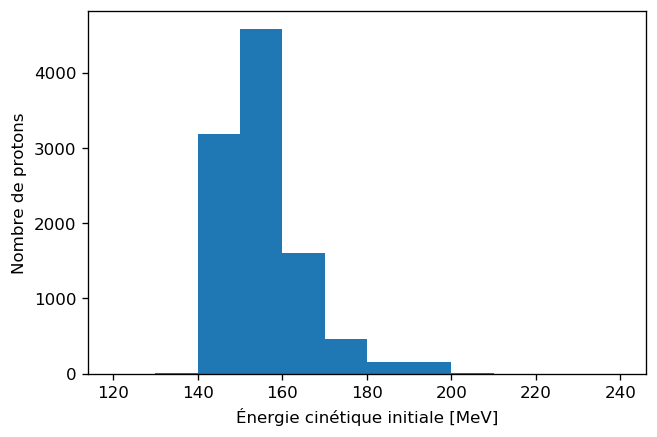

In [ ]:
from scipy.stats import moyal
import matplotlib.pyplot as plt
%matplotlib inline


sample = moyal(loc=150, scale=4).rvs(size=10000)

plt.figure(dpi=120)
groupes = [120, 130, 140, 150, 160, 170, 180, 200, 210, 220, 240]
plt.hist(sample, bins=groupes)
plt.xlabel('Énergie cinétique initiale [MeV]')
plt.ylabel('Nombre de protons')
plt.show()

On veut ensuite déterminer le nombre de portées de protons que chaque méthode d'intégration peut calculer en 1 seconde. Pour ce faire, on utilise le module *timeit* et on calcule le temps nécessaire pour calculer les 10 000 portées pour chaque méthode d'intégration:

In [ ]:
#TODO: Déterminer le nombre de tranches nécessaire pour atteindre la précision de la fonction de scipy (2**i)

# Méthode des trapèzes

portees_trapeze = []

t_1 = timeit.default_timer()
for p in sample:
    portees_trapeze.append(portee(1, 0, p, 'eau', 'trapeze'))
t_2 = timeit.default_timer()


# Méthode de Romberg

portees_romberg = []

t_3 = timeit.default_timer()
for p in sample:
    portees_romberg.append(portee(1, 0, p, 'eau', 'romberg'))
t_4 = timeit.default_timer()


# Fonction scipy.integrate.quad

portees_scipy = []

def integrande(T):
    return 1000 * milieu['eau'][1] * inv_pouvoir_arret(T, 'eau')

t_5 = timeit.default_timer()
for p in sample:
    portees_scipy.append(sp.integrate.quad(integrande, 0, p)[0])
t_6 = timeit.default_timer()


print("Temps pour la méthode des trapèzes :", t_2-t_1, "secondes")
print("Temps pour la méthode de Romberg :", t_4-t_3, "secondes")
print("Temps pour la fonction native de scipy :", t_6-t_5, "secondes")

C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Temps pour la méthode des trapèzes : 0.49433539999995446 secondes
Temps pour la méthode de Romberg : 0.3949852999999166 secondes
Temps pour la fonction native de scipy : 21.183439800000087 secondes


On trace un histogramme des portées obtenues pour les 10 000 protons:

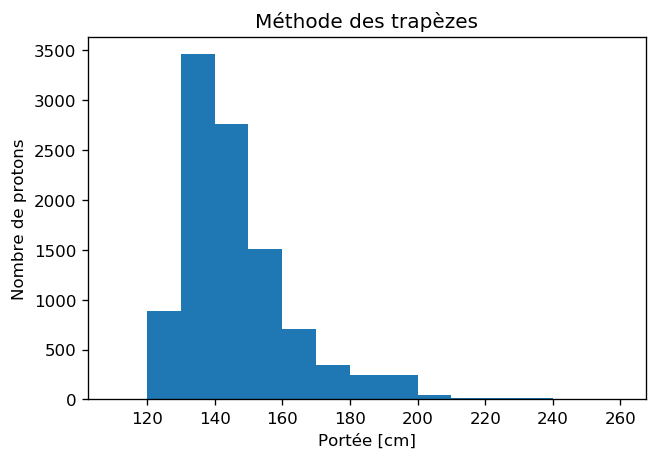

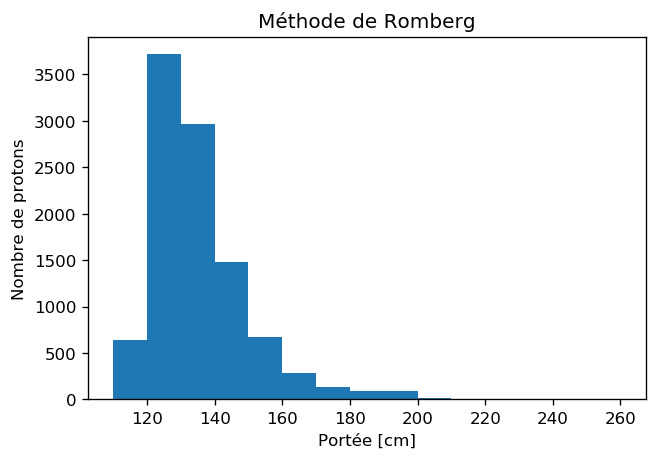

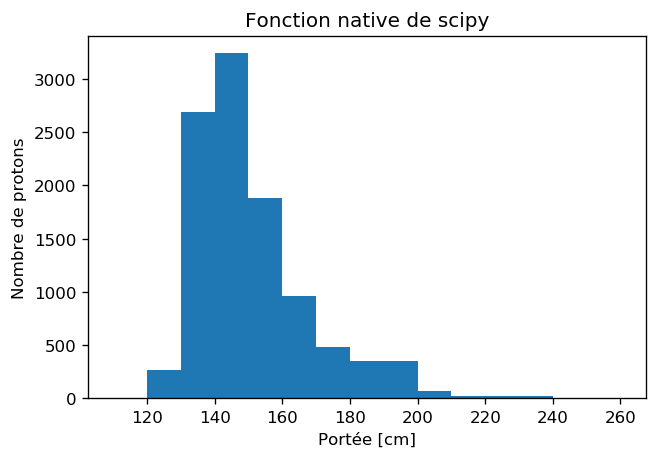

In [ ]:
groupes_2 = [110, 120, 130, 140, 150, 160, 170, 180, 200, 210, 220, 240, 250, 260]

plt.figure(dpi=120)
plt.hist(portees_trapeze, bins=groupes_2)
plt.title("Méthode des trapèzes")
plt.xlabel('Portée [cm]')
plt.ylabel('Nombre de protons')
plt.show()

plt.figure(dpi=120)
plt.hist(portees_romberg, bins=groupes_2)
plt.title("Méthode de Romberg")
plt.xlabel('Portée [cm]')
plt.ylabel('Nombre de protons')
plt.show()

plt.figure(dpi=120)
plt.hist(portees_scipy, bins=groupes_2)
plt.title("Fonction native de scipy")
plt.xlabel('Portée [cm]')
plt.ylabel('Nombre de protons')
plt.show()

ICI IL VA FALLOIR EXPLIQUER DU STOCK QUAND ON AURA LES DONNÉES AVEC LE BON NOMBRE DE TRANCHES

# Énergie déposée

On veut maintenant caractériser le dépôt d'énergie dans le milieu. On sait que, lorsque le proton passe d'une énergie $T_i$ à une énergie $T_f$, le pas de déplacement $s$ du proton est donné par
$$s = \int_{T_f}^{T_i}\frac{\text{d}T'}{S_{col}}$$

On crée d'abord une fonction qui calcule le pas de déplacement en fonction de l'énergie transférée au milieu:

In [ ]:
def pas(T_i, T_f, mil):
    def fonction(T):
         return inv_pouvoir_arret(T, mil)
    return sp.integrate.quad(fonction, T_f, T_i)[0]

# Question 12, version alternative

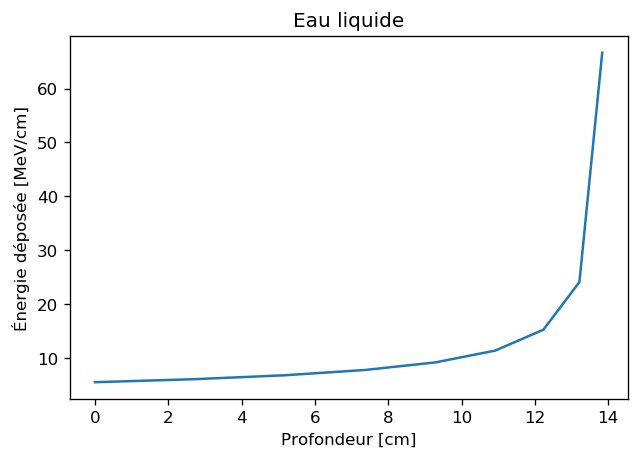

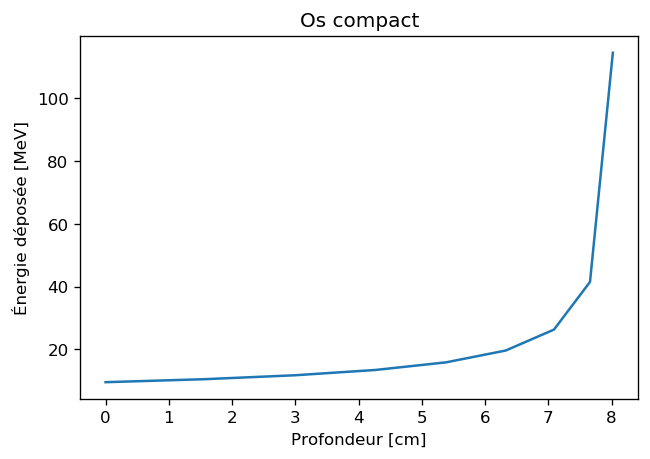

In [ ]:
def energie_deposee(T_i, T_f, mil, n):
    s = []
    x = []
    T = np.linspace(T_f, T_i, n)
    depot = []
    for i in range(n-1):
        s.append(pas(T[-i-1], T[-i-2], mil) * 100)
        x.append(sum(s[:-1]))
        depot.append(T_i/n / s[-1])
    return depot, x


# Eau liquide
d_e, x_e = energie_deposee(150, 0, 'eau', 10)

plt.figure(dpi=120)
plt.title("Eau liquide")
plt.xlabel("Profondeur [cm]")
plt.ylabel("Énergie déposée [MeV/cm]")
plt.plot(x_e, d_e)
plt.show()

# Os compact
d_o, x_o = energie_deposee(150, 0, 'os', 10)

plt.figure(dpi=120)
plt.title("Os compact")
plt.xlabel("Profondeur [cm]")
plt.ylabel("Énergie déposée [MeV]")
plt.plot(x_o, d_o)
plt.show()

On conçoit ensuite un algorithme qui détermine l'énergie déposée par le proton selon la position de celui-ci:

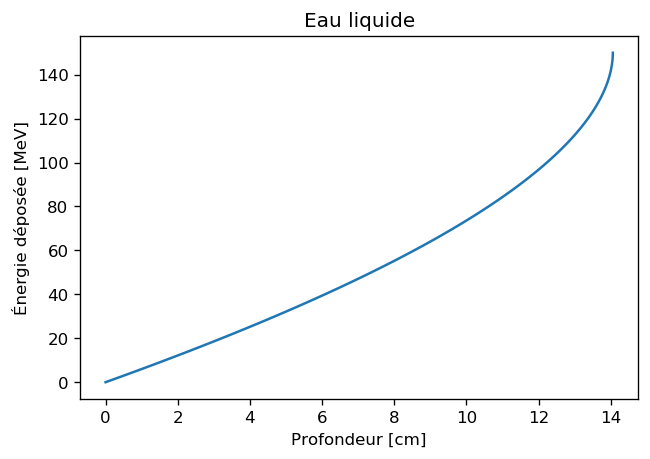

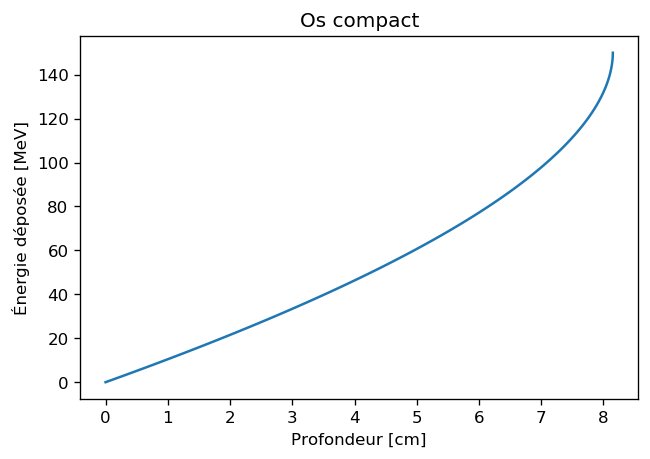

In [ ]:
def energie_deposee(T_i, T_f, mil, n):
    s = []
    T = np.linspace(T_f, T_i, n)
    for i in range(n):
        s.append(pas(T_i, T[n-i-1], mil) * 100)
    return T, s

# Eau liquide
T_e, s_e = energie_deposee(150, 0, 'eau', 100)

plt.figure(dpi=120)
plt.title("Eau liquide")
plt.xlabel("Profondeur [cm]")
plt.ylabel("Énergie déposée [MeV]")
plt.plot(s_e, T_e)
plt.show()

# Os compact
T_o, s_o = energie_deposee(150, 0, 'os', 100)

plt.figure(dpi=120)
plt.title("Os compact")
plt.xlabel("Profondeur [cm]")
plt.ylabel("Énergie déposée [MeV]")
plt.plot(s_o, T_o)
plt.show()